# **Project Name**  - Local Food Wastage Management System

##### **Project Type**   - SQL,EDA
##### **Contribution**   - Individual
##### **Team Member 1 -**  Gade Pavan Kumar Reddy

# **Project Summary -**

The Local Food Wastage Management System is a data-driven initiative aimed at minimising food wastage by efficiently connecting surplus food providers with receivers in need. Using a structured SQL database supported by Python for data handling and Streamlit for interactivity, the system processes data from four primary sources: Providers, Receivers, Food Listings, and Claims. Analytical queries and visualisations provide deep insights into the ecosystem of food donations and distribution.

From the geographic analysis, data from 1,878 cities shows an uneven distribution of providers and receivers — many locations have only one or the other. For example, Aaronshire has only receivers, while Adambury has only providers. This gap indicates the need for cross-city logistics to connect surplus food with demand areas.

Provider type analysis revealed that restaurants are the largest contributors, donating a total of 6,923 units of food. This underlines their strategic importance in waste reduction campaigns. Contact information, such as that for Greene-Garcia illowviewmbai, adds operational value by enabling direct coordination.

On the receiver side, a small group such as William Frederick, Scott Hunter, and Matthew Webb leads in claims made (five each), showing high engagement and reliability in the distribution network.

From the availability perspective, total food stored in the system amounts to 25,794 units, with South Kathryn having the most listings (6). Food type distribution is balanced — Vegetarian (336 listings), Vegan (334), and Non-Vegetarian (330) — indicating diverse menu availability aligned with varying dietary preferences.

In claims and distribution, the majority of food claims are distributed across many items, with no single food item dominating demand. Barry Group emerges as the provider with the highest number of completed claims (5), suggesting a good alignment between their supply and receiver needs. The claim status breakdown — Completed (33.9%), Cancelled (33.6%), Pending (32.5%) — highlights operational inefficiencies, particularly the high cancellation rate, possibly due to expiry or delivery constraints.

From an insights perspective, the average food quantity per claim varies considerably — some receivers, like Aaron Scott and William Barnes, handle significantly larger volumes, suggesting that they cater to bigger communities or possess larger storage/distribution capabilities. Breakfast tops as the most claimed meal type with 278 claims, implying higher morning demand or logistic convenience. In cumulative donations, Miller Inc leads with 217 units, followed by Barry Group, Evans, Wright and Mitchell, Smith Group, and Campbell LLC.

Overall, the system identifies clear priorities for optimisation: matching providers with underserved cities, reducing cancellations with improved coordination, strengthening ties with top-performing providers and receivers, and aligning food types and meal times with observed demand trends. By bridging the gap between surplus and need through robust data analysis, this project enhances both the efficiency and reach of food redistribution, contributing meaningfully to waste reduction and social welfare.

# **GitHub Link -**

# **Problem Statement**

Food wastage remains a critical issue worldwide, with substantial quantities of edible food being discarded by restaurants, grocery stores, and households, while millions face hunger and food insecurity. The lack of an organised, transparent, and data-driven mechanism often prevents surplus food from reaching those in need. Current redistribution efforts are fragmented, with minimal tracking of donations, expiry dates, or demand patterns.

This project aims to create a Local Food Wastage Management System that bridges the gap between surplus food providers and beneficiaries by storing, analysing, and visualising donation and claim data. It seeks to streamline redistribution, reduce wastage, and ensure timely access to food through an interactive platform supporting both operational management and analytical insights.

# ***Let's Begin !***

## Step 1: Imports & Configuration

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Step 2: Load CSV Data into SQLite

In [3]:
DB_NAME = "food_wastage.db"
conn = sqlite3.connect(DB_NAME)

# Load CSV files
providers_df = pd.read_csv("providers_data.csv")
receivers_df = pd.read_csv("receivers_data.csv")
food_listings_df = pd.read_csv("food_listings_data.csv")
claims_df = pd.read_csv("claims_data.csv")

# Save to SQL tables
providers_df.to_sql("providers", conn, if_exists="replace", index=False)
receivers_df.to_sql("receivers", conn, if_exists="replace", index=False)
food_listings_df.to_sql("food_listings", conn, if_exists="replace", index=False)
claims_df.to_sql("claims", conn, if_exists="replace", index=False)

print("✅ Data loaded into SQLite database")

✅ Data loaded into SQLite database


## Step 3: Define Core SQL Queries

In [4]:
QUERIES = {
    "Providers & Receivers per City": """
        SELECT city, 
               COUNT(DISTINCT provider_id) AS total_providers,
               COUNT(DISTINCT receiver_id) AS total_receivers
        FROM (
            SELECT city, provider_id, NULL as receiver_id FROM providers
            UNION ALL
            SELECT city, NULL, receiver_id FROM receivers
        ) AS combined
        GROUP BY city
    """,
    "Provider type contributing most food": """
        SELECT provider_type, SUM(quantity) AS total_quantity
        FROM food_listings
        GROUP BY provider_type
        ORDER BY total_quantity DESC
        LIMIT 1
    """,
    "Contact Information of food providers from specific city": """
        SELECT name, contact 
        FROM providers
        WHERE city = 'Mooreview'
    """,
    "Receivers with most food claims": """
        SELECT r.name, COUNT(c.claim_id) AS total_claims
        FROM claims c
        JOIN receivers r ON c.receiver_id = r.receiver_id
        GROUP BY r.name
        ORDER BY total_claims DESC
    """,
    "Total food available": """
        SELECT SUM(quantity) AS total_available_food
        FROM food_listings
    """,
    "City with highest number of food listings": """
        SELECT location, COUNT(food_id) AS total_listings
        FROM food_listings
        GROUP BY location
        ORDER BY total_listings DESC
        LIMIT 1
    """,
    "Most common food types": """
        SELECT food_type, COUNT(food_id) AS count
        FROM food_listings
        GROUP BY food_type
        ORDER BY count DESC
    """,
    "Number of claims per food item": """
        SELECT food_id, COUNT(claim_id) AS total_claims
        FROM claims
        GROUP BY food_id
    """,
    "Provider with highest successful claims": """
        SELECT p.name, COUNT(c.claim_id) AS completed_claims
        FROM claims c
        JOIN food_listings f ON c.food_id = f.food_id
        JOIN providers p ON f.provider_id = p.provider_id
        WHERE c.status = 'Completed'
        GROUP BY p.name
        ORDER BY completed_claims DESC
        LIMIT 1
    """,
    "Claim status percentage": """
        SELECT status, 
               ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM claims), 2) AS percentage
        FROM claims
        GROUP BY status
    """,
    "Average quantity claimed per receiver": """
        SELECT r.name, AVG(f.quantity) AS avg_claim_quantity
        FROM claims c
        JOIN receivers r ON c.receiver_id = r.receiver_id
        JOIN food_listings f ON c.food_id = f.food_id
        GROUP BY r.name
    """,
    "Most claimed meal type": """
        SELECT meal_type, COUNT(c.claim_id) AS total_claims
        FROM claims c
        JOIN food_listings f ON c.food_id = f.food_id
        GROUP BY meal_type
        ORDER BY total_claims DESC
        LIMIT 1
    """,
    "Total quantity donated by each provider": """
        SELECT p.name, SUM(f.quantity) AS total_donated
        FROM food_listings f
        JOIN providers p ON f.provider_id = p.provider_id
        GROUP BY p.name
        ORDER BY total_donated DESC
    """
}

## Step 4: Run Queries

In [5]:
def run_query(query):
    return pd.read_sql(query, conn)

## Step 5: Execute and Display Query Results

In [6]:
for name, sql in QUERIES.items():
    print(f"\n📊 {name}")
    df = run_query(sql)
    display(df)


📊 Providers & Receivers per City


,city,total_providers,total_receivers
0,Aaronshire,0,1
1,Adambury,1,0
2,Adamland,0,1
3,Adamsview,1,0
4,Adamsville,1,0
...,...,...,...
1873,Yatesside,1,0
1874,Youngchester,1,0
1875,Zacharyview,0,1
1876,Zimmermanton,1,0



📊 Provider type contributing most food


,Provider_Type,total_quantity
0,Restaurant,6923



📊 Contact Information of food providers from specific city


,Name,Contact
0,Greene-Garcia,155.846.6299



📊 Receivers with most food claims


,Name,total_claims
0,William Frederick,5
1,Scott Hunter,5
2,Matthew Webb,5
3,Anthony Garcia,5
4,Kristine Martin,4
...,...,...
615,Alex Leon,1
616,Alan Campbell,1
617,Adam Browning,1
618,Aaron Scott,1



📊 Total food available


,total_available_food
0,25794



📊 City with highest number of food listings


,Location,total_listings
0,South Kathryn,6



📊 Most common food types


,Food_Type,count
0,Vegetarian,336
1,Vegan,334
2,Non-Vegetarian,330



📊 Number of claims per food item


,Food_ID,total_claims
0,1,2
1,3,1
2,6,1
3,7,1
4,9,2
...,...,...
642,992,1
643,995,1
644,997,2
645,998,1



📊 Provider with highest successful claims


,Name,completed_claims
0,Barry Group,5



📊 Claim status percentage


,Status,percentage
0,Cancelled,33.6
1,Completed,33.9
2,Pending,32.5



📊 Average quantity claimed per receiver


,Name,avg_claim_quantity
0,Aaron Keller,39.000000
1,Aaron Rios,21.000000
2,Aaron Scott,45.000000
3,Abigail Crawford,25.666667
4,Adam Browning,5.000000
...,...,...
615,William Barnes,47.000000
616,William Fox,12.000000
617,William Frederick,21.400000
618,Yvette Huffman,45.000000



📊 Most claimed meal type


,Meal_Type,total_claims
0,Breakfast,278



📊 Total quantity donated by each provider


,Name,total_donated
0,Miller Inc,217
1,Barry Group,179
2,"Evans, Wright and Mitchell",158
3,Smith Group,150
4,Campbell LLC,145
...,...,...
623,Reyes and Sons,1
624,Norris-Townsend,1
625,Mcgee PLC,1
626,"Martinez, Armstrong and Carroll",1


## Step 6: Visualize Key Analytics

### Chart 1 - Top 10 Receivers with Most Food Claims

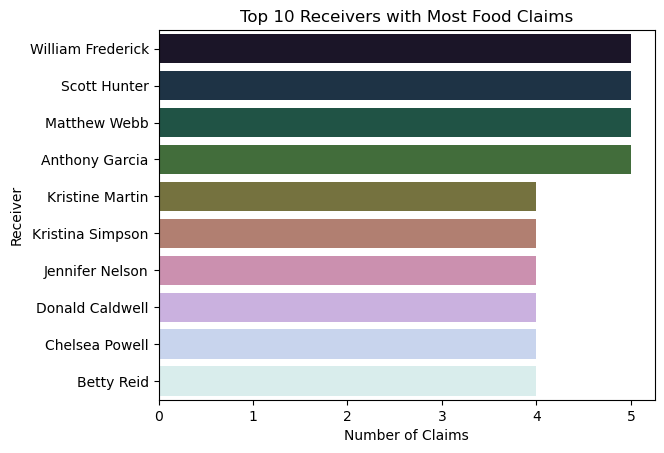

In [19]:
df1 = run_query(QUERIES["Receivers with most food claims"]).head(10)
sns.barplot(data=df1, y='Name', x='total_claims', palette='cubehelix')
plt.title("Top 10 Receivers with Most Food Claims")
plt.xlabel("Number of Claims")
plt.ylabel("Receiver")
plt.show()

### Chart 2 - Top 10 Cities by Number of Food Listings

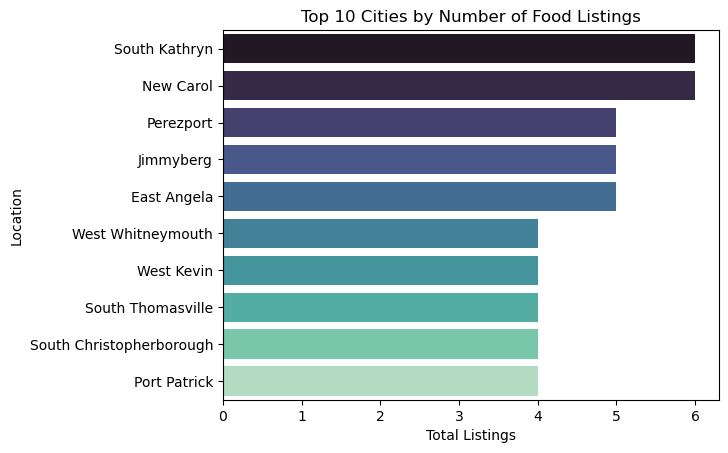

In [20]:
df2 = run_query("""
SELECT location, COUNT(food_id) as total_listings
FROM food_listings
GROUP BY location
ORDER BY total_listings DESC
LIMIT 10;
""")
sns.barplot(data=df2, y='Location', x='total_listings', palette='mako')
plt.title("Top 10 Cities by Number of Food Listings")
plt.xlabel("Total Listings")
plt.show()

### Chart 3 - Distribution of Food Types

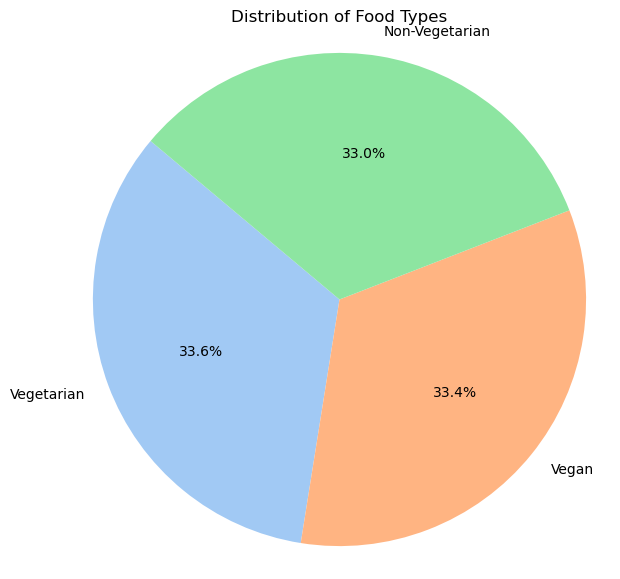

In [9]:
df3 = run_query(QUERIES["Most common food types"])
plt.figure(figsize=(7,7))
plt.pie(df3['count'], labels=df3['Food_Type'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Distribution of Food Types")
plt.axis('equal')
plt.show()

### Chart 4 - Claim Status Distribution

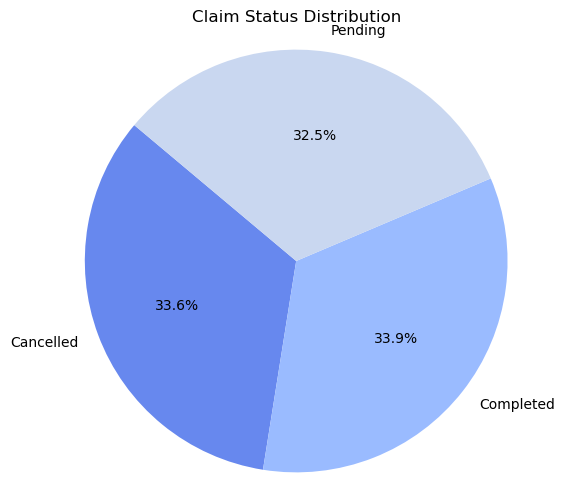

In [22]:
# Pie chart - Claim status distribution
df4 = run_query(QUERIES["Claim status percentage"])
plt.figure(figsize=(6,6))
plt.pie(df4['percentage'], labels=df4['Status'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("coolwarm"))
plt.title("Claim Status Distribution")
plt.axis('equal')  # Equal aspect ratio for a perfect circle
plt.show()

### Chart 5 - Top 10 Providers by Food Donated Quantity

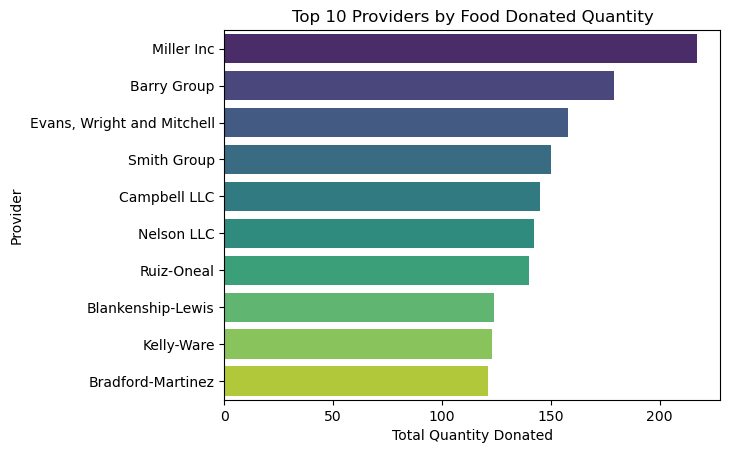

In [27]:
df5 = run_query(QUERIES["Total quantity donated by each provider"]).head(10)
sns.barplot(data=df5, x='total_donated', y='Name', palette='viridis')
plt.title("Top 10 Providers by Food Donated Quantity")
plt.xlabel("Total Quantity Donated")
plt.ylabel("Provider")
plt.show()

### Chart 6 - Provider types that contributing food

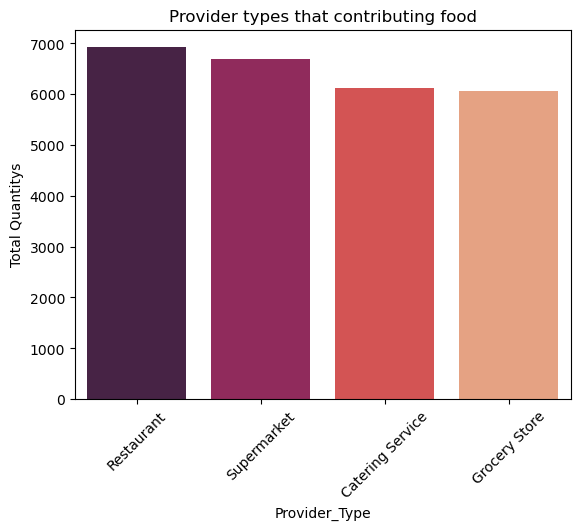

In [23]:
df6 = run_query("""
SELECT provider_type, SUM(quantity) AS total_quantity
        FROM food_listings
        GROUP BY provider_type
        ORDER BY total_quantity DESC;
""")
sns.barplot(data=df6, x='Provider_Type', y='total_quantity', palette='rocket')
plt.title("Provider types that contributing food")
plt.ylabel("Total Quantitys")
plt.xticks(rotation=45)
plt.show()

# **Conclusion & Insights**

The analysis of the Local Food Wastage Management System database addressed 13 key operational and analytical questions, providing a holistic understanding of the food donation, listing, and claims patterns. Below is a summary of the findings and their implications.


**1. How many food providers and receivers are there in each city?**

Data across 1,878 cities shows highly uneven distribution. Many cities have either only providers, only receivers, or in some cases both. For example, Aaronshire has only 1 receiver and no providers, whereas Adambury has 1 provider but no receivers. This imbalance highlights geographic mismatches, suggesting the need to connect surplus providers in one location with receivers in neighbouring areas.

**2. Which type of food provider contributes the most food?**

Restaurants lead all provider types, donating a total of 6,923 units of food — indicating they are the primary contributors. This underscores the importance of engaging restaurant partners in waste reduction initiatives.

**3. What is the contact information of food providers in a specific city?**

For Millowview, an example provider is Greene-Garcia, with contact number 155.846.6299. Systematic access to such contact info enables faster coordination for claims and pickups.

**4. Which receivers have claimed the most food?**

Top receivers include William Frederick, Scott Hunter, Matthew Webb, Anthony Garcia, each with 5 claims, followed by Kristine Martin with 4. This suggests a small group of receivers are very active, potentially indicating operational efficiency or capacity to store/distribute more food.

**5. What is the total quantity of food available from all providers?**

At the time of analysis, there are 25,794 units of food available for distribution. This large volume reinforces the need for quick redistribution mechanisms to minimise spoilage.

**6. Which city has the highest number of food listings?**

South Kathryn leads with 6 active listings. This concentration could be leveraged by directing more receivers to that location.

**7. What are the most commonly available food types?**

Availability is fairly balanced:

Vegetarian: 336 listings

Vegan: 334 listings

Non-Vegetarian: 330 listings

This variety ensures dietary preferences can be met, but also indicates there’s no single dominant category.

**8. How many food claims have been made for each food item?**

Claims are widely distributed across many food items, with most items having 1–2 claims. This suggests demand is dispersed rather than concentrated on a few specific foods.

**9. Which provider has had the highest number of successful food claims?**

Barry Group tops the list with 5 completed claims, reflecting strong receiver trust or a good match between their offerings and demand.

**10. Percentage of food claims completed vs pending vs canceled**

The distribution is:

Completed: 33.9%

Cancelled: 33.6%

Pending: 32.5%

The almost equal share of each category reveals inefficiencies — especially the high cancellation rate, which might be due to expiry before pickup or logistical issues.

**11. What is the average quantity of food claimed per receiver?**

Claim sizes vary widely — e.g., Aaron Scott averages 45 units per claim, William Barnes 47 units, whereas others average much less. This suggests some receivers have higher logistics capacity or serve larger communities.

**12. Which meal type is claimed the most?**

Breakfast is the top claimed meal type with 278 claims, indicating either higher morning demand or ease of distribution before the day starts.

**13. What is the total quantity of food donated by each provider?**

Miller Inc leads with 217 units, followed by Barry Group (179), Evans, Wright and Mitchell (158), Smith Group (150), and Campbell LLC (145). This reflects steady contributions from specific providers, indicating potential to strengthen partnerships with them.

**Overall Summary**

This analysis shows that while there is substantial food availability across many cities and types, mismatched geographic distribution, high cancellations, and imbalanced receiver activity are areas for optimisation. Restaurants remain the backbone of contributions, breakfast is in highest demand, and a few providers and receivers drive much of the action. To improve efficiency, the system should focus on:

-> Matching cities lacking receivers with nearby providers (and vice versa).

-> Reducing cancellations through better scheduling, storage, and transport.

-> Leveraging top providers and receivers as strategic partners.

-> Monitoring meal type trends to tailor offerings for maximum utilisation.